In [93]:
from pydantic_graph import BaseNode, End, GraphRunContext, Graph
from pydantic_ai import Agent
from pydantic_ai.common_tools.tavily import tavily_search_tool
from dataclasses import dataclass
from pydantic import Field, BaseModel
from typing import Dict, List
from pydantic_ai.models.gemini import GeminiModel
from pydantic_ai.providers.google_gla import GoogleGLAProvider
from dotenv import load_dotenv
import os
from tavily import TavilyClient
from IPython.display import Image, display


load_dotenv()

True

In [94]:
google_api_key=os.getenv('google_api_key')
tavily_key=os.getenv('tavily_key')

In [95]:
tavily_client = TavilyClient(api_key=tavily_key)

In [96]:
llm=GeminiModel('gemini-2.0-flash', provider=GoogleGLAProvider(api_key=google_api_key))

In [97]:
@dataclass
class State:
    query:str
    preliminary_research: str
    research_plan: List
    research_results: List
    validation : str
    final: str



In [98]:
search_agent=Agent(llm, tools=[tavily_search_tool(tavily_key)], system_prompt="do a websearch based on the query")

In [99]:
paper_gen_agent=Agent(llm, system_prompt="syntheze the information based on the query, preliminary_search, and search_results and provide an analysis of the information, include url sources")

In [100]:
@dataclass
class PaperGen_node(BaseNode[State]):
    async def run(self, ctx: GraphRunContext[State])->End:
        prompt=(f'Based on this query:{ctx.state.query}, and this preliminary_search:{ctx.state.preliminary_research}, and the search_results:{ctx.state.research_results}, synthesize the information.')
        result=await paper_gen_agent.run(prompt)
        ctx.state.final=result.data
        return End(result.data)


In [101]:
@dataclass
class Research_node(BaseNode[State]):
    async def run(self, ctx: GraphRunContext[State])->PaperGen_node:
        data=[]
        for i in ctx.state.research_plan:
            response = tavily_client.search(i.search_query)
            search_results=[]
            for i in response.get('results'):
                if i.get('score')>0.50:
                    search_data={'content':i.get('content'),'url':i.get('url')}
                    search_results.append(search_data)
            data.append(search_results)
        ctx.state.research_results.append(data)
        return PaperGen_node()

In [102]:
@dataclass
class Tasks:
    task: str = Field(description='the task to complete')
    search_query: str = Field(description='the detailed web search query based on the task')

In [103]:
@dataclass
class Research_plan:
    Plan: List[Tasks]

In [104]:
research_plan_agent=Agent(llm, result_type=Research_plan, system_prompt='generate a research plan based on the query and the preliminary search')

In [105]:
@dataclass
class Research_plan_node(BaseNode[State]):
    async def run(self, ctx: GraphRunContext[State])->Research_node:
        
        prompt=(f'generate a detailed research plan breaking down the research into smaller parts based on this query:{ctx.state.query} and this preliminary_search:{ctx.state.preliminary_research}')
        result=await research_plan_agent.run(prompt)
        ctx.state.research_plan=result.data.Plan
        return Research_node()


In [106]:
@dataclass
class preliminary_search_node(BaseNode[State]):
    async def run(self, ctx: GraphRunContext[State]) -> Research_plan_node:
        prompt = (' Do a preliminary search to get a global idea of the subject that the user wants to do reseach on as well as the necessary informations to do a search on.\n'
                  f'The subject is based on the query: {ctx.state.query}, return the results of the search.')
        result=await search_agent.run(prompt)
        ctx.state.preliminary_research=result.data
        return Research_plan_node()



In [107]:
graph=Graph(nodes=[preliminary_search_node, Research_plan_node, Research_node, PaperGen_node])

In [108]:
state=State(query='what are the most popular pos companies (eg. toast) for restaurants in nyc and make a breakdown of their services and featuresa and prices', preliminary_research='', research_plan=[], research_results=[], validation='', final='')

In [109]:
async def main():
    res=await graph.run(preliminary_search_node(),state=state)
    return res

In [110]:
async def main_iter():
    async with graph.iter(preliminary_search_node(),state=state) as run:
        async for node in run:
            print(node)



In [111]:
res=await main_iter()

Research_plan_node()
Research_node()
PaperGen_node()
End(data="Okay, based on the search results, here's a breakdown of popular POS systems for restaurants in NYC, including their services, features, and pricing:\n\n**1. Toast POS**\n\n*   **Popularity:**  Toast appears to be a very popular choice for restaurants, and is specifically designed for the restaurant industry.\n*   **Key Features:**\n    *   Online ordering.\n    *   Digital and physical loyalty and gift card programs.\n    *   Workforce management tools (including scheduling, payroll, and team management).\n    *   Tableside ordering and payments.\n    *   Digital receipts.\n    *   Reporting and analytics.\n    *   Menu management.\n    *   Inventory management.\n    *   Real-time fraud monitoring.\n    *   Multi-location management.\n    *   Automatic software updates.\n    *   Offline mode.\n    *   Employee management (tip pool calculations, onboarding).\n    *   Website management.\n    *   Email marketing.\n\n*   **Pr

In [71]:
image=graph.mermaid_image()

In [112]:
print(state.final)

Okay, based on the search results, here's a breakdown of popular POS systems for restaurants in NYC, including their services, features, and pricing:

**1. Toast POS**

*   **Popularity:**  Toast appears to be a very popular choice for restaurants, and is specifically designed for the restaurant industry.
*   **Key Features:**
    *   Online ordering.
    *   Digital and physical loyalty and gift card programs.
    *   Workforce management tools (including scheduling, payroll, and team management).
    *   Tableside ordering and payments.
    *   Digital receipts.
    *   Reporting and analytics.
    *   Menu management.
    *   Inventory management.
    *   Real-time fraud monitoring.
    *   Multi-location management.
    *   Automatic software updates.
    *   Offline mode.
    *   Employee management (tip pool calculations, onboarding).
    *   Website management.
    *   Email marketing.

*   **Pricing:**
    *   Subscription-based model.
    *   Pricing varies based on the size o

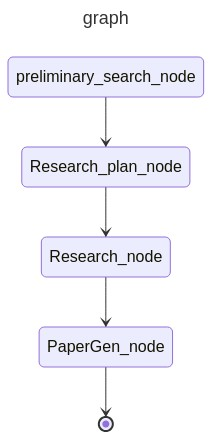

In [26]:
display(Image(image))

In [19]:
res= await main()
res


C:\Users\trist\AppData\Local\Temp\ipykernel_7556\806949340.py:2: LogfireNotConfiguredWarning: No logs or spans will be created until `logfire.configure()` has been called. Set the environment variable LOGFIRE_IGNORE_NO_CONFIG=1 or add ignore_no_config=true in pyproject.toml to suppress this warning.
  res=await graph.run(preliminary_search_node(),state=state)


GraphRuntimeError: Invalid node return type: `ABCMeta`. Expected `BaseNode` or `End`.

In [1]:
from deep_research import Deep_research_engine


In [2]:
research_engine=Deep_research_engine()

In [3]:
res=await research_engine.chat('what are some snake species in the bahamas near george town and which are venomous')

c:\Users\trist\OneDrive\Desktop\important\ai_portfolio\deep_research_agent\deep_research.py:95: LogfireNotConfiguredWarning: No logs or spans will be created until `logfire.configure()` has been called. Set the environment variable LOGFIRE_IGNORE_NO_CONFIG=1 or add ignore_no_config=true in pyproject.toml to suppress this warning.
  response=await self.graph.run(preliminary_search_node(),state=State(query={query}, preliminary_research='', research_plan=[], research_results=[], validation='', final=''))


In [7]:
print(res.output)

Okay, here's a synthesis of information about snakes in the Bahamas, focusing on species and venomous status, while acknowledging the lack of specific focus on George Town in the search results.

**Snake Species in the Bahamas:**

Based on the search results, the following snake species are found in the Bahamas:

*   Blind Snake (various types, including the Bahamian Slender Blind Snake)
*   Thread Snake
*   Pygmy Boa ( *Tropidophis canus* is one endemic species)
*   Brown Racer (also referred to as garden snake)
*   Bahamian Boa Constrictor
*   Corn Snake (invasive species)

**Venomous Status:**

There is conflicting information regarding venomous snakes in the Bahamas.

*   Some sources claim the Brown Racer is the *only* venomous snake in the Bahamas. ([https://www.travelsafe-abroad.com/snakes-in-the-bahamas/](https://www.travelsafe-abroad.com/snakes-in-the-bahamas/))
*   Some state there are *no* venomous snakes in the Bahamas that are harmful to humans ([https://www.travelsafe-abr